<a href="https://colab.research.google.com/github/hkvision/BigDL/blob/update-colab/python/dllib/colab-notebook/dllib_keras_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

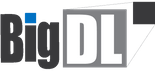

##### Copyright 2016 The BigDL Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install bigdl-dllib**

You can install the latest pre-release version using `pip install --pre --upgrade bigdl-dllib`. 

In [2]:
# Install latest pre-release version of bigdl-dllib with spark3
!pip install --pre --upgrade bigdl-dllib-spark3

exit() # restart the runtime to refresh installed pkg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.5 MB 1.5 MB/s 
     |████████████████████████████████| 212.4 MB 63 kB/s 
     |████████████████████████████████| 51.0 MB 41 kB/s 
     |████████████████████████████████| 198 kB 64.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880769 sha256=8cd2018dc032b90ff2d9baee9a604e4295f669dba60b8f42ae8b9cc415798bb8
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


## **Distributed NN model using DLlib keras-style api for classification**

In this guide we will demonstrate how to use dllib keras-style api to build a model for classification in 5 simple steps.

#### **Step 0: Intialization** 

import necessary libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from bigdl.dllib.nncontext import *
from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import Sequential
from bigdl.dllib.nnframes import *
from bigdl.dllib.nn.criterion import *

Init NNContext and create Spark session

In [2]:
ZooContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

sc = init_nncontext(cluster_mode="local") # run in local mode
spark = SparkSession(sc)

Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/core/lib/all-2.1.0-20220314.094552-2.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.2-2.1.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


#### **Step 1: Load the data** 

We used [Pima Indians onset of diabetes](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv) as dataset for the demo. It's a standard machine learning dataset from the UCI Machine Learning repository. It describes patient medical record data for Pima Indians and whether they had an onset of diabetes within five years.    

For more details about the data, please refer [here](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names)





##### ***Download the data***


In [3]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv

--2022-07-25 12:48:05--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23278 (23K) [text/plain]
Saving to: ‘pima-indians-diabetes.data.csv’

pima-indians-diabet 100%[===================>]  22.73K  --.-KB/s    in 0s      

2022-07-25 12:48:05 (75.6 MB/s) - ‘pima-indians-diabetes.data.csv’ saved [23278/23278]




DLlib supports Spark Dataframes as the input to the distributed training, and as the input/output of the distributed inference. Consequently, the user can easily process large-scale dataset using Apache Spark, and directly apply AI models on the distributed (and possibly in-memory) Dataframes without data conversion or serialization   

##### **Load the data into Spark dataframe using Spark API**

In [4]:
path = "pima-indians-diabetes.data.csv"
df = spark.read.csv(path, sep=',', inferSchema=True).toDF("num_times_pregrant", "plasma_glucose", "blood_pressure", "skin_fold_thickness", "2-hour_insulin", "body_mass_index", "diabetes_pedigree_function", "age", "class")

In [5]:
df.show()

+------------------+--------------+--------------+-------------------+--------------+---------------+--------------------------+---+-----+
|num_times_pregrant|plasma_glucose|blood_pressure|skin_fold_thickness|2-hour_insulin|body_mass_index|diabetes_pedigree_function|age|class|
+------------------+--------------+--------------+-------------------+--------------+---------------+--------------------------+---+-----+
|                 6|           148|            72|                 35|             0|           33.6|                     0.627| 50|    1|
|                 1|            85|            66|                 29|             0|           26.6|                     0.351| 31|    0|
|                 8|           183|            64|                  0|             0|           23.3|                     0.672| 32|    1|
|                 1|            89|            66|                 23|            94|           28.1|                     0.167| 21|    0|
|                 0|       

#### **Step 2: Process data using Spark DataFrame api** 


In [6]:
vecAssembler = VectorAssembler(outputCol="features")
vecAssembler.setInputCols(["num_times_pregrant", "plasma_glucose", "blood_pressure", "skin_fold_thickness", "2-hour_insulin", "body_mass_index", "diabetes_pedigree_function", "age"])
train_df = vecAssembler.transform(df)

changedTypedf = train_df.withColumn("label", train_df["class"].cast(DoubleType())+lit(1))\
    .select("features", "label")
(trainingDF, validationDF) = changedTypedf.randomSplit([0.9, 0.1])

#### **Step 3: Define model using DLlib keras-style api** 


In [7]:
x1 = Input(shape=(8,))
dense1 = Dense(12, activation='relu')(x1)
dense2 = Dense(8, activation='relu')(dense1)
dense3 = Dense(2)(dense2)
model = Model(x1, dense3)

creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel


#### **Step 4: Create NNClassifier**

In [8]:
classifier = NNClassifier(model, CrossEntropyCriterion(), [8]) \
    .setOptimMethod(Adam()) \
    .setBatchSize(32) \
    .setMaxEpoch(150)

creating: createCrossEntropyCriterion
creating: createScalarToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier
creating: createAdam


Train the model with Spark dataframe

In [9]:
nnModel = classifier.fit(trainingDF)

2022-07-25 12:48:01.051 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Auto detect executor number and executor cores number
2022-07-25 12:48:01.071 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Executor number is 1 and executor cores number is 2
2022-07-25 12:48:02.680 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.utils.ThreadPool$ - Set mkl threads to 1 on thread 16
2022-07-25 12:48:02.698 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.utils.Engine$ - Find existing spark context. Checking the spark conf...
2022-07-25 12:48:37.236 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.keras.models.InternalDistriOptimizer$ - Model[b206d17d] isTorch is false
2022-07-25 12:48:37.279 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - caching training rdd ...
2022-07-25 12:48:39.055 [Thread-3] INFO  com.intel.analytics.bigdl.dllib.optim.DistriOptimizer$ - Cache thread models...
2022-07-25 12:48:39.199 [Executor task launch worker f

#### **Step 5: Evaluate the trained model**

In [10]:
predictionDF = nnModel.transform(validationDF).cache()
predictionDF.sample(False, 0.1).show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionDF)

print("Accuracy = %g " % (accuracy))

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.0,91.0,68.0,32...|  1.0|       1.0|
|[0.0,125.0,96.0,0...|  1.0|       1.0|
|[5.0,88.0,66.0,21...|  1.0|       1.0|
|[5.0,147.0,78.0,0...|  1.0|       1.0|
|[9.0,154.0,78.0,3...|  1.0|       1.0|
|[10.0,92.0,62.0,0...|  1.0|       1.0|
+--------------------+-----+----------+

Accuracy = 0.662162 
